# Third Project Work Week Assignment
### Authors: Dan Davieau, Paul Panek, Olga Tanyuk, Nathan Wall

### Initial Data Prep

For the purpose of this assignment we view the data prep as conditional to the specific classification task. However, there are several minor data cleaning tasks that are applicable to either task and are performed in the code below

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/default of credit card clients.csv')
df.rename(columns={'Default':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)
df["log_BILL_AMT1"]=np.log(df.BILL_AMT1.abs()+1)
df["log_BILL_AMT2"]=np.log(df.BILL_AMT2.abs()+1)
df["log_BILL_AMT3"]=np.log(df.BILL_AMT3.abs()+1)
df["log_BILL_AMT4"]=np.log(df.BILL_AMT4.abs()+1)
df["log_BILL_AMT5"]=np.log(df.BILL_AMT5.abs()+1)
df["log_BILL_AMT6"]=np.log(df.BILL_AMT6.abs()+1)

df['COLLEGE'] = np.where(df['EDUCATION']==2, 1, 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 38 columns):
LIMIT_BAL        30000 non-null float64
SEX              30000 non-null int64
EDUCATION        30000 non-null int64
MARRIAGE         30000 non-null int64
AGE              30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
BILL_AMT1        30000 non-null float64
BILL_AMT2        30000 non-null float64
BILL_AMT3        30000 non-null float64
BILL_AMT4        30000 non-null float64
BILL_AMT5        30000 non-null float64
BILL_AMT6        30000 non-null float64
PAY_AMT1         30000 non-null float64
PAY_AMT2         30000 non-null float64
PAY_AMT3         30000 non-null float64
PAY_AMT4         30000 non-null float64
PAY_AMT5         30000 non-null float64
PAY_AMT6         30000 non-null

# Predicting Customer "Default"
The first portion of the report we will explore various models to try and classify customer's likelihood of default.

### Modeling & Evaluation Considerations



### Data Preperation - Default Classification Specific
Below we perform several steps that explain some of the data preparation tasks that are specific to the goal of classifying customers default on credit card payments.

First we remove the variables that we identified as not important from Lab1 & Mini-Lab1. We also one hot encode our categorical features for use in our models. Below you will find the fields that are considered in our model.

Field Definitions:
- The items in the final data set are shown below.
- Monetary amounts are in New Taiwanese dollars
- SEX
    * 1 = Male
    * 2 = Female
- AGE = Credit Card holder age in years
- default: Whether or not the customer defaulted (Target for predicting default)
- Payment history (2005)
- PAY_0 = September
- PAY_2 = August
- PAY_3 = July
- PAY_4 = June
- PAY_5 = May
- PAY_6 = April
-1 = payment received on time
    - 1 = payment received one month late
    - 2 = payment received two months late
    - 9 = payment received nine months late or more
- log_LIMIT_BAL: Natural log of the Credit Limit (max amount of credit allowed)
- log_PAY_AMT: Natural log of the amount paid by month + $1
- log_PAY_AMT1 = September
- log_PAY_AMT2 = August
- log_PAY_AMT3 = July
- log_PAY_AMT4 = June
- log_PAY_AMT5 = May
- log_PAY_AMT6 = April
- EDUCATION (One-Hot Encoded when Predicting Default. Used in the form below when used as target.)
- EDUCATION_1 = Graduate School
- EDUCATION_2 = University
- EDUCATION_3 = High School
- EDUCATION_4 = Other
- EDUCATION (This variable appears only as the target only when predicting Education. Not one-hot encoded.)
- 1 = Graduate School
- 2 = University
- 3 = High School
- 4 = Other
- MARRIAGE (One-Hot Encoded)
- MARRIAGE_1 = Married
- MARRIAGE_2 = Single
- MARRIAGE_3 = Other

In [2]:
#Create a separate dataset with only useful variables as identified in Lab1 and Mini-lab1.
default = df[['SEX','EDUCATION','MARRIAGE','AGE', 'default'
            ,'PAY_0',"log_LIMIT_BAL"
            ,"log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5"
            ,"log_PAY_AMT6"]]

# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(default.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(default.MARRIAGE,prefix='MARRIAGE')
default = pd.concat((default,tmp_df_1,tmp_df_2),axis=1)
#Drop variables for which we used one-hot encoding
del default['EDUCATION']
del default['MARRIAGE']
y = default['default']
#Lets normalize the data
df_imputed = (default-default.mean())/default.std()
df_imputed['default'] = y

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 18 columns):
SEX              30000 non-null float64
AGE              30000 non-null float64
default          30000 non-null int64
PAY_0            30000 non-null float64
log_LIMIT_BAL    30000 non-null float64
log_PAY_AMT1     30000 non-null float64
log_PAY_AMT2     30000 non-null float64
log_PAY_AMT3     30000 non-null float64
log_PAY_AMT4     30000 non-null float64
log_PAY_AMT5     30000 non-null float64
log_PAY_AMT6     30000 non-null float64
EDUCATION_1      30000 non-null float64
EDUCATION_2      30000 non-null float64
EDUCATION_3      30000 non-null float64
EDUCATION_4      30000 non-null float64
MARRIAGE_1       30000 non-null float64
MARRIAGE_2       30000 non-null float64
MARRIAGE_3       30000 non-null float64
dtypes: float64(17), int64(1)
memory usage: 4.3 MB


Once the dataset is cleaned and the variables are prepared, it makes sense to try and cluster AGE and log_LIMIT_BAL together and separately. It is unclear exactly where to make the classes discrete and how many levels we should make, so we will try a few different parameterizations to investigate this.

## Baseline Classification Performance


Let's start by performing 10 fold cross validation and using the raw features in a Random Forest classifer. Let's get the average accuracy of classifying whether a person default or not from the cleaned data set.

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

df =  df_imputed.sample(10000)
y = df['default']
X = df[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                'AGE','PAY_0',"log_LIMIT_BAL","log_PAY_AMT1",
                "log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
cv = StratifiedKFold(n_splits=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  81.5401952302 +- 0.825220763301


Now let's start with a bit of feature engineering. We will start by using kmeans on AGE and log_LIMIT_BAL together.

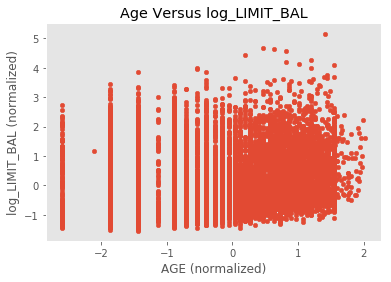

In [4]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = df[['AGE','log_LIMIT_BAL']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('AGE (normalized)'), plt.ylabel('log_LIMIT_BAL (normalized)')
plt.grid()
plt.title('Age Versus log_LIMIT_BAL')
plt.show()

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X1 = df[['AGE','log_LIMIT_BAL']]

cls = KMeans(n_clusters=14, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df['default']
X = df[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                'PAY_0',"log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for class/fare)=  81.4501652202 +- 0.632507656421


So it seems that the average accuracy of the folds has stayed about the same, and the deviation from the mean was not improved. Let's now try clustering only one of the features.

In [6]:
from sklearn.cluster import KMeans
import numpy as np

X2 = df[['AGE']]

cls = KMeans(n_clusters=14, init='k-means++',random_state=1)
cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df['default']
X = df[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                'PAY_0',"log_PAY_AMT1",'log_LIMIT_BAL',"log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for Age/Family)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for Age/Family)=  81.2901650602 +- 0.637283844108


In this case we got an improved accuracy and deviation.

Lets vary the parameters for Age and log_LIMIT_BAL, and see what works the best.

In [8]:
%%time 

X1 = df[['AGE']]
X2 = df[['log_LIMIT_BAL']]

params = []
for n_age in range(10,14):
    for n_bal in range(10,21):
        # get the first clustering
        cls_age = KMeans(n_clusters=n_age, init='k-means++',random_state=1)
        cls_age.fit(X1)
        newfeature_age = cls_age.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_bal = KMeans(n_clusters=n_bal, init='k-means++',random_state=1)
        cls_bal.fit(X2)
        newfeature_bal = cls_bal.labels_ # the labels from kmeans clustering

        y = df['default']
        X = df[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                'PAY_0',"log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
        X = np.column_stack((X,pd.get_dummies(newfeature_age),pd.get_dummies(newfeature_bal)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_age,n_bal,acc.mean()*100,acc.std()*100)) # save state

        print ("Clusters",n_age,n_bal,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 10 10 Average accuracy =  81.3302850603 +- 0.747573859729
Clusters 10 11 Average accuracy =  81.3202350502 +- 0.844485384007
Clusters 10 12 Average accuracy =  81.2302949303 +- 0.802958667769
Clusters 10 13 Average accuracy =  81.0803048203 +- 0.663273310729
Clusters 10 14 Average accuracy =  81.2403249603 +- 0.70824406072
Clusters 10 15 Average accuracy =  81.3002350302 +- 0.630055232999
Clusters 10 16 Average accuracy =  81.3302851203 +- 0.725915761153
Clusters 10 17 Average accuracy =  81.3501950702 +- 0.650159094996
Clusters 10 18 Average accuracy =  81.1603149503 +- 0.797679108063
Clusters 10 19 Average accuracy =  81.1702349302 +- 0.725621444921
Clusters 10 20 Average accuracy =  81.2704250604 +- 0.963150115941
Clusters 11 10 Average accuracy =  80.9701147501 +- 0.537890496873
Clusters 11 11 Average accuracy =  81.1301249201 +- 0.793057922145
Clusters 11 12 Average accuracy =  81.1302347902 +- 0.725751681055
Clusters 11 13 Average accuracy =  81.0901748902 +- 0.464591245


It seems that about the best we can do with these new discretization methods is around 81.59%. All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable. 

Let's see if we can make things simpler by only clustering on one of attributes.

In [7]:
params = []
for n_age in range(10,15):

    # append on the clustering
    cls_age = KMeans(n_clusters=n_age, init='k-means++',random_state=1)
    cls_age.fit(X1)
    newfeature_age = cls_age.labels_ # the labels from kmeans clustering

    y = df['default']
    X = df[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','log_LIMIT_BAL','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                'PAY_0',"log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
    X = np.column_stack((X,pd.get_dummies(newfeature_age)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    
    print ("Clusters",n_age,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 10 Average accuracy =  81.1402349702 +- 0.757100559137
Clusters 11 Average accuracy =  81.1901650002 +- 0.745632930082
Clusters 12 Average accuracy =  81.1001849002 +- 0.871246237683
Clusters 13 Average accuracy =  81.0801849002 +- 0.630955224671
Clusters 14 Average accuracy =  81.1402550303 +- 0.752836836496


So it seems that the accuracy is fairly stagnant. Now, let's also try to replace features using some slightly different clustering algorithms and see what works best for classification.

In [9]:
%%time 

from sklearn.cluster import AgglomerativeClustering

X1 = df[['AGE','log_LIMIT_BAL']]

params = []
for link in ['ward', 'complete', 'average']:
    for n in range(12,20):

        # append on the clustering
        cls = AgglomerativeClustering(n_clusters=n, linkage=link)
        cls.fit(X1)
        newfeature = cls.labels_ # the labels from kmeans clustering

        y = df['default']
        X = df[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                'PAY_0',"log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
        X = np.column_stack((X,pd.get_dummies(newfeature)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n,acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

C= 12 ward Average accuracy =  81.2099250199 +- 0.650511172113
C= 13 ward Average accuracy =  81.1800750301 +- 0.643589596467
C= 14 ward Average accuracy =  81.08002494 +- 0.506180607084
C= 15 ward Average accuracy =  81.1799349899 +- 0.483500302879
C= 16 ward Average accuracy =  81.2599250599 +- 0.601020187152
C= 17 ward Average accuracy =  81.2698850399 +- 0.703268222077
C= 18 ward Average accuracy =  81.23998498 +- 0.70203982834
C= 19 ward Average accuracy =  81.2599250399 +- 0.628686640389
C= 12 complete Average accuracy =  81.0301147901 +- 0.762266289218
C= 13 complete Average accuracy =  81.1801149901 +- 0.67283576821
C= 14 complete Average accuracy =  81.2201050001 +- 0.671851384101
C= 15 complete Average accuracy =  81.15001491 +- 0.487432566733
C= 16 complete Average accuracy =  81.1300649601 +- 0.639606655249
C= 17 complete Average accuracy =  81.1601149301 +- 0.81821110217
C= 18 complete Average accuracy =  81.2401550102 +- 0.591835348567
C= 19 complete Average accuracy =  8

Again, all fairly good performances using different types of linkage and also different numbers of clusters. Let's now try DBSCAN.

In [10]:
%%time 

from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(2,6):

        # append on the clustering
        cls = DBSCAN(eps=eps, min_samples=mpts)
        cls.fit(X1)
        newfeature = cls.labels_ # the labels from kmeans clustering

        y = df['default']
        X = df[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                'PAY_0',"log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
        X = np.column_stack((X,pd.get_dummies(newfeature)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n,acc.mean()*100,acc.std()*100)) # save state

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

0.1 2 Average accuracy =  81.1300249 +- 0.672678130272
0.1 3 Average accuracy =  81.2401450001 +- 0.666475113437
0.1 4 Average accuracy =  81.0702048602 +- 0.784594619257
0.1 5 Average accuracy =  80.96003483 +- 0.765817342925
0.125 2 Average accuracy =  80.99002482 +- 0.672280132588
0.125 3 Average accuracy =  81.15001501 +- 0.641700373606
0.125 4 Average accuracy =  81.0701249201 +- 0.430379584593
0.125 5 Average accuracy =  81.0101448601 +- 0.649201376425
0.15 2 Average accuracy =  80.7200646801 +- 0.503077271204
0.15 3 Average accuracy =  80.9302147502 +- 0.489605272263
0.15 4 Average accuracy =  81.0102948103 +- 0.619445844306
0.15 5 Average accuracy =  81.0101348301 +- 0.584717648786
Wall time: 6min 10s


It seems that DBSCAN has good clusterings for this dataset that are able to capture some of the nuances for the attributes.

## Visualizing different clusters

Now lets take the best performers from each methods and show the clustering that they found in the data.

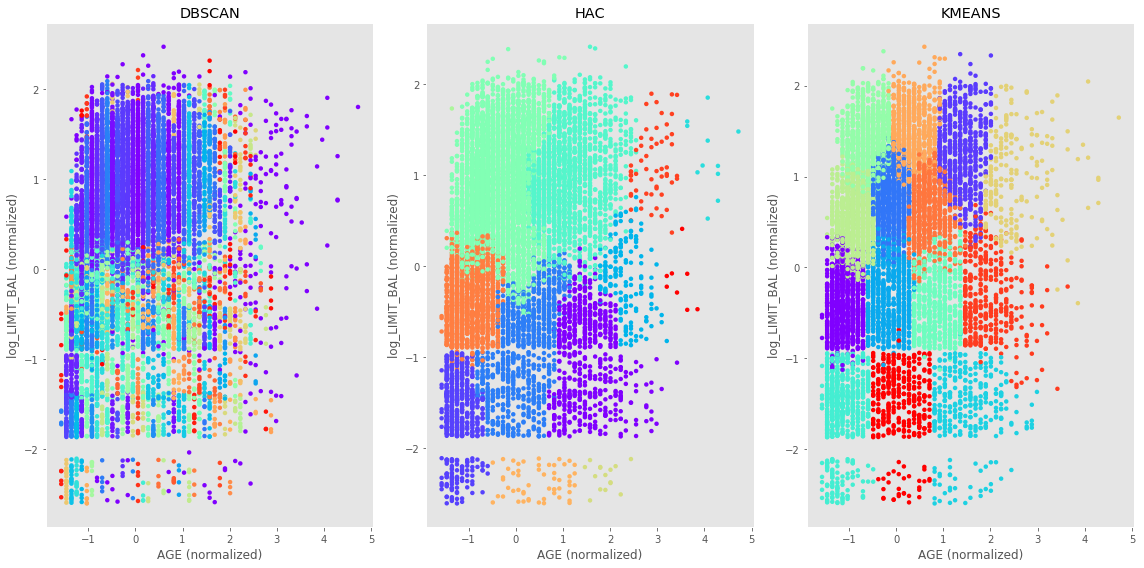

In [11]:

data = X1

cls = DBSCAN(eps=0.1, min_samples=3)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=13, linkage='average')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=14, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(16,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(1,3,i+1)
    plt.scatter(data.AGE, data.log_LIMIT_BAL+np.random.random(data.log_LIMIT_BAL.shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('AGE (normalized)'), plt.ylabel('log_LIMIT_BAL (normalized)')
    plt.grid()
    plt.title(title[i])
      


plt.tight_layout()
plt.show()